In [1]:
import pandas as pd
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
import spacy
import string

import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [3]:
covid19 = pd.read_csv("../data/covid19.csv")

In [4]:
covid19_abstract = covid19[['Abstract','Title']].dropna().reset_index(drop = True)

In [5]:
covid19_abstract.head()

,Abstract,Title
0,Approximately 90 days of the SARS-CoV-2 (COVID...,Urgent need for individual mobile phone and in...
1,The current outbreak of coronavirus SARS-CoV-2...,Nuclear medicine in SARS-CoV-2 pandemia: 18F-F...
2,"In late December 2019, Chinese health authorit...",COVID-19 Outbreak: An Overview.
3,The global spread of COVID-19 has caused sudde...,Clinician Wellness During the COVID-19 Pandemi...
4,Coronavirus disease 2019 (COVID-19) was first ...,Risk of nosocomial transmission of coronavirus...


In [6]:
stop_words = stopwords.words('english')
nlp = spacy.load('en', disable=['parser', 'ner'])
# clean the text using below for loop
clean_text = []
for index in range(len(covid19_abstract)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', covid19_abstract['Abstract'][index])

    #Convert to lowercase
    text = text.lower()
    
    #remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Convert to list of words from text
    text = text.split()
    
    # remove stop words after splitting text and joint the words
    text =[word for word in text if word not in stop_words]
    text = " ".join(text)
    # lemmatize words using spacy
    
    doc = nlp(text)
    text=" ".join([token.lemma_ for token in doc])

   # append to clean_text
    clean_text.append(text)
    
covid19_abstract['clean_text'] = clean_text

In [7]:
covid19_abstract.head()

,Abstract,Title,clean_text
0,Approximately 90 days of the SARS-CoV-2 (COVID...,Urgent need for individual mobile phone and in...,approximately days sars cov covid spread origi...
1,The current outbreak of coronavirus SARS-CoV-2...,Nuclear medicine in SARS-CoV-2 pandemia: 18F-F...,current outbreak coronavirus sars cov reach mu...
2,"In late December 2019, Chinese health authorit...",COVID-19 Outbreak: An Overview.,late december chinese health authority report ...
3,The global spread of COVID-19 has caused sudde...,Clinician Wellness During the COVID-19 Pandemi...,global spread covid cause sudden dramatic soci...
4,Coronavirus disease 2019 (COVID-19) was first ...,Risk of nosocomial transmission of coronavirus...,coronavirus disease covid first report wuhan d...


In [8]:
covid19_abstract.shape

(3179, 3)

In [9]:
covid19_abstract.to_csv('../data/covid_clean_text.csv', index = False)

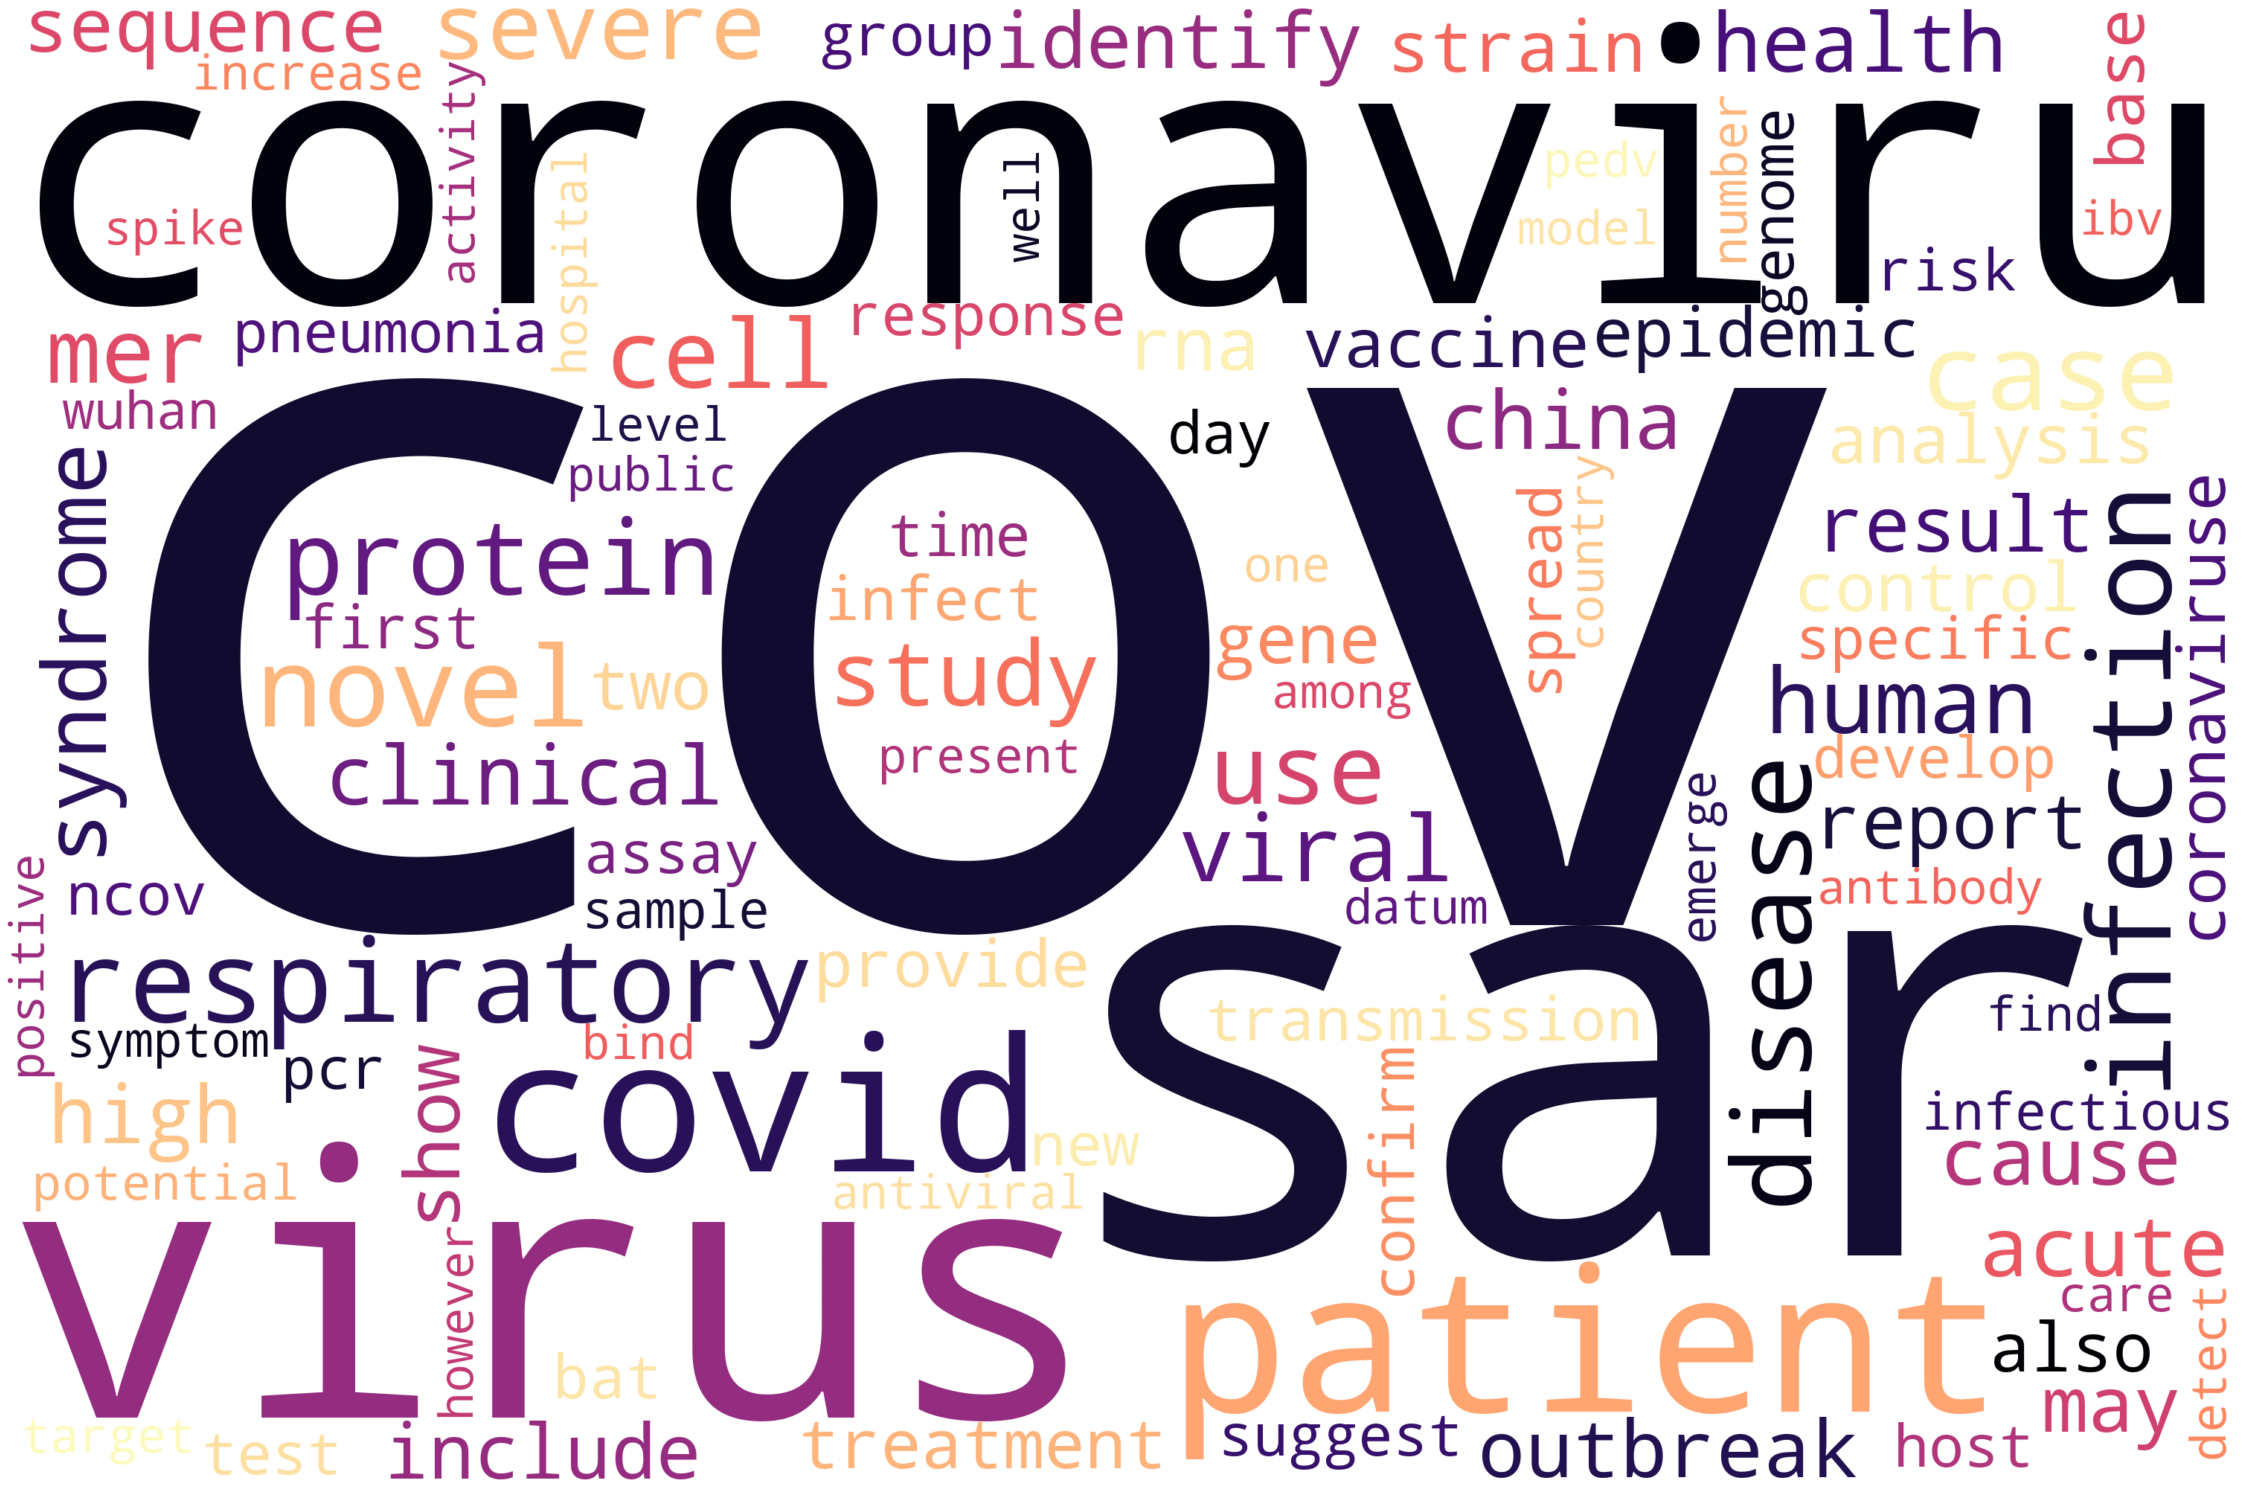

In [10]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/wordcloud_covid19.png")
plt.show()

In [11]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall','however', 'confirm','present','perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term','operate',
                'characteristics', 'whole','slide','supplementary', 'significantly', 'improvement','wide','range',
               'hand','craft','open','source','ci','see','outperform']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
213
392


In [12]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(clean_text)

In [13]:
clean_text = [" ".join(x) for x in minus_stopwords]

In [14]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

['global', 'spread', 'covid', 'cause', 'sudden', 'dramatic', 'societal', 'change', 'allergy', 'immunology', 'community', 'quickly', 'respond', 'mobilize', 'practice', 'adjustment', 'embrace', 'paradigm', 'care', 'protect', 'patient', 'staff', 'sars', 'cov', 'exposure', 'social', 'distancing', 'key', 'slow', 'contagion', 'add', 'complexity', 'care', 'isolation', 'anxiety', 'uncertainty', 'exist', 'across', 'covid', 'reality', 'clinician', 'wellbeing', 'priority', 'wellness', 'incorporate', 'mental', 'physical', 'spiritual', 'health', 'protect', 'burnout', 'impair', 'cope', 'caregive', 'ability', 'understand', 'stressor', 'covid', 'place', 'clinician', 'assist', 'recognize', 'need', 'return', 'point', 'wellness', 'clinician', 'leverage', 'easily', 'accessible', 'include', 'strength', 'mean', 'orient', 'resilience', 'transformation', 'smart', 'wellness', 'apps', 'mindfulness', 'gratitude', 'realize', 'early', 'warning', 'sign', 'anxiety', 'depression', 'substance', 'abuse', 'post', 'traum

In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
lemmatized_words = lemmatization(words_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [17]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                   Bigram       Freq
0           public health  33.909234
1      infectious disease  25.518767
2            severe acute  21.587226
3       acute respiratory  17.557620
4         immune response  17.508771
5       respiratory tract  16.180238
6         viral infection  15.241887
7           spike protein  14.970377
8              amino acid  14.018883
9        polymerase chain  13.858854
10        genome sequence  13.678910
11         chain reaction  13.672188
12  infectious bronchitis  13.599748
13            health care  13.411771
14      respiratory virus  13.368290
15       health emergency  13.137289
16        control measure  13.137169
17    respiratory disease  13.137158
18              case case  12.736029
19          covid patient  12.296424
20  reverse transcription  12.127374
21       bronchitis virus  11.872288
22          disease cause  11.864057
23            novel virus  11.863465
24            full length  11.512971
25     antiviral activity  11.378172
2

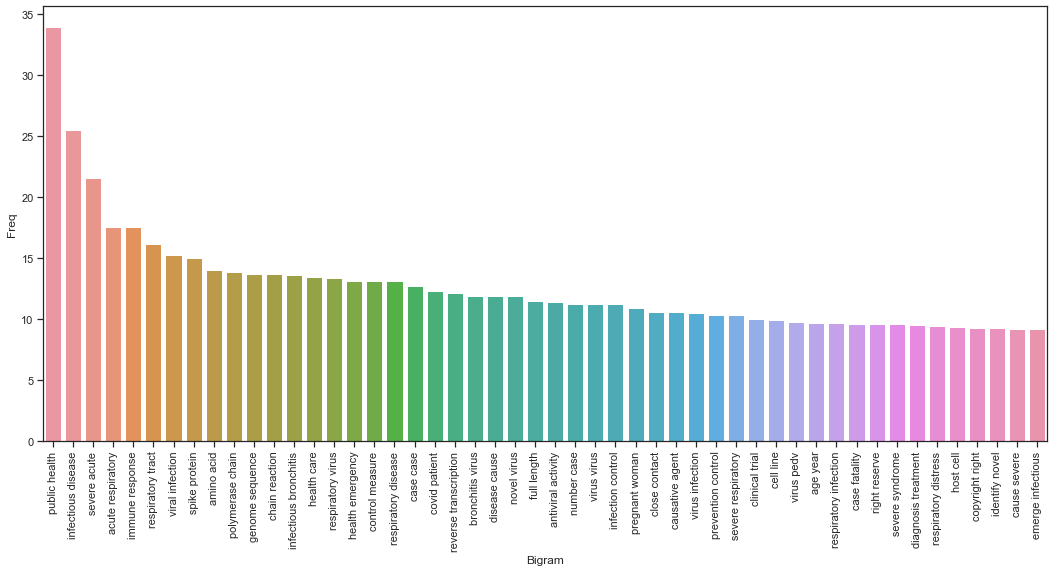

In [18]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in lemmatized_words]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 2,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

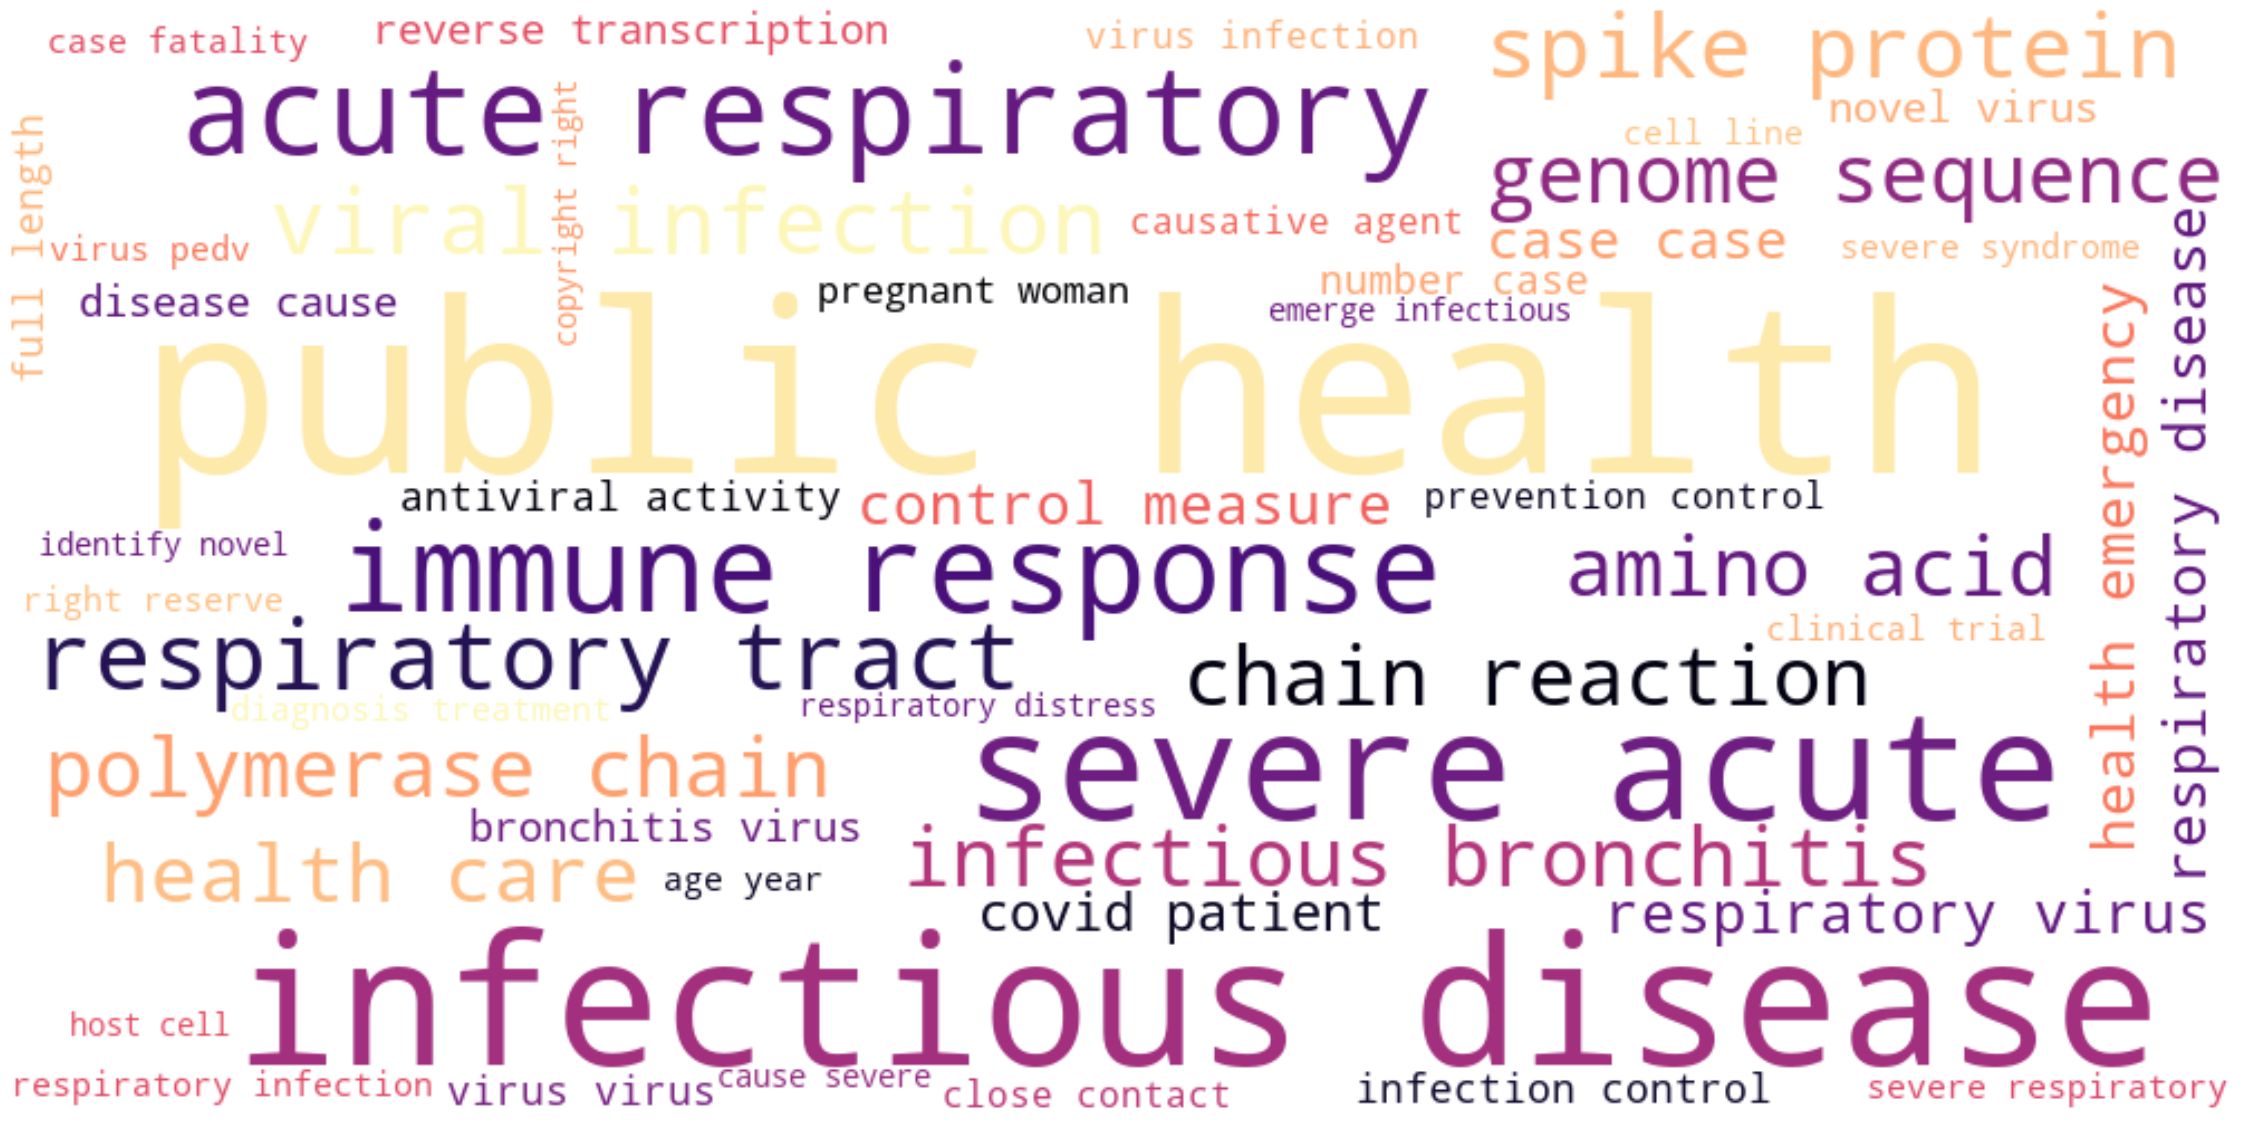

In [19]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                      relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_covid19.png", bbox_inches='tight')
plt.show()

In [20]:
bigram = Phrases(lemmatized_words, min_count=1, threshold=100)
trigram = Phrases(lemmatized_words, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [21]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(lemmatized_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(lemmatized_words)

In [22]:
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [23]:
#data_lemme = lemmatization(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 3), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 3), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 5), (65, 3), (66, 2), (67, 2), (68, 1), (69, 4), (70, 2), (71, 1), (72, 1), (73, 2), (74, 2), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1)], [(2, 1), (6, 1), (14, 1), (17, 1), (18, 1), (24, 1), (67, 1), (70, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 

In [25]:
id2word[21]

'delay'

In [26]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=14, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=25,
                     alpha='auto',
                     per_word_topics=True)

In [27]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"virus" + 0.031*"severe" + 0.027*"disease" + 0.024*"human" + '
  '0.023*"novel" + 0.021*"cause" + 0.018*"respiratory" + 0.017*"infection" + '
  '0.016*"identify" + 0.012*"spread"'),
 (1,
  '0.087*"protein" + 0.024*"identify" + 0.017*"viral" + 0.017*"sequence" + '
  '0.016*"coronaviruse" + 0.016*"domain" + 0.016*"site" + 0.015*"fusion" + '
  '0.014*"structure" + 0.014*"epitope"'),
 (2,
  '0.041*"virus" + 0.035*"infection" + 0.022*"viral" + 0.021*"antiviral" + '
  '0.018*"cell" + 0.015*"activity" + 0.014*"response" + 0.014*"host" + '
  '0.012*"immune" + 0.011*"target"'),
 (3,
  '0.033*"cancer" + 0.021*"surgery" + 0.019*"participant" + 0.012*"operation" '
  '+ 0.011*"transplant" + 0.011*"surgical" + 0.011*"score" + 0.010*"lab" + '
  '0.009*"must" + 0.009*"anxiety"'),
 (4,
  '0.097*"sequence" + 0.068*"gene" + 0.059*"strain" + 0.049*"virus" + '
  '0.033*"isolate" + 0.029*"genome" + 0.022*"leader" + 0.015*"novel" + '
  '0.013*"variant" + 0.013*"genetic"'),
 (5,
  '0.095*"group"

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.247309361819505

Coherence Score:  0.5319578701859294


In [29]:
# code repurposed from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

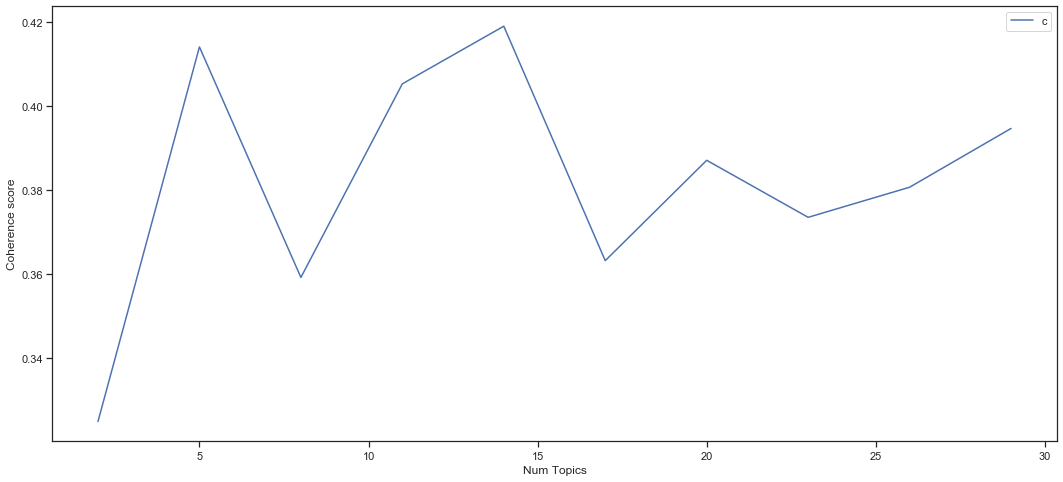

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.102604  0.188093       1        1  17.198353
0      0.183063  0.089018       2        1  12.579589
13     0.116215  0.199555       3        1  10.476168
12     0.165670 -0.178614       4        1  10.262517
2      0.151251 -0.038235       5        1  10.170311
11     0.154226  0.004650       6        1   9.612174
10     0.055112  0.244755       7        1   9.571655
1      0.123342 -0.207177       8        1   8.144377
4      0.094298 -0.201737       9        1   5.566122
5     -0.084330 -0.103946      10        1   2.494478
7     -0.240075 -0.021457      11        1   1.394105
3     -0.274042  0.027256      12        1   1.192680
8     -0.269938 -0.011877      13        1   1.041654
9     -0.277397  0.009717      14        1   0.295820, topic_info=     Category         Freq       Term        Total  loglift  logprob
542   Default  2404.000000    protein  2404.000000  30.0000  30.0000
261   Default  2735.000000    patient  2735.000000  29.0000  29.0000
677   Default  1936.000000       cell  1936.000000  28.0000  28.0000
1856  Default  1334.000000   sequence  1334.000000  27.0000  27.0000
163   Default  4233.000000      virus  4233.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
1752  Topic14     3.132004  transport    14.503047   4.2905  -5.2277
1085  Topic14     3.068975  principle    23.605244   3.7830  -5.2480
334   Topic14     3.981851   estimate   205.960007   1.8772  -4.9876
119   Topic14     2.869319       rise    48.557915   2.9945  -5.3153
515   Topic14     1.647468    exclude    14.107977   3.6757  -5.8701

[847 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1191      3  0.959333  abnormality
3630     11  0.946132      abolish
3971     14  0.801481     absolute
797       5  0.934779   accumulate
797       9  0.033385   accumulate
...     ...       ...          ...
2111      3  0.904072        young
2111     13  0.080108        young
3339     12  0.915318         zone
1551      2  0.887686     zoonotic
1551     10  0.107962     zoonotic

[1571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 14, 13, 3, 12, 11, 2, 5, 6, 8, 4, 9, 10])

In [32]:
pyLDAvis.save_html(vis, '../data/ldacovid.html')